# SET Card Detection
This Jupyter notebook shows each step of the card detection algorithm.

## Import necessary packages

In [42]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import platform
from imutils import paths

In [43]:
print(f"Python version: {platform.python_version()}")
print(f"{cv.__name__} version: {cv.__version__}")
print(f"{np.__name__} version: {np.__version__}")

Python version: 3.9.16
cv2 version: 4.7.0
numpy version: 1.25.1


## Get paths to game images

In [44]:
path = "../images/sample/"

In [45]:
image_paths = list(paths.list_images(path))
print(f"{len(image_paths)} images in images directory")

1 images in images directory


In [46]:
image_paths

['../images/sample/IMG_5254.JPG']

## Dictionary of Card Attributes

In [47]:
# dictionary of card attributes converting integer values from card vectors to strings
SET_MAP = {"shape": {0: "diamond", 1: "oval", 2: "squiggle"},
           "color": {0: "red", 1: "green", 2: "purple"},
           "shading": {0: "solid", 1: "open", 2: "stripe"},
           "number": {0: "one", 1: "two", 2: "three"},
           }

LABELS_MAP = {"shape": {"diamond": 0, "oval": 1, "squiggle": 2},
              "color": {"red": 0, "green": 1, "purple": 2},
              "shading": {"solid": 0, "open": 1, "stripe": 2},
              "number": {"one": 0, "two": 1, "three": 2}
              }

## Create a class for SET cards

In [48]:
class SetCard:
    # structure to store information about SET cards

    def __init__(self):
        self.image = []  # image of individual card
        self.card_contour = []  # contour of card
        self.bbox = []  # bounding rectangle of card  on image (x, y, w, h)
        self.box = []  # coordinates of four corners for minimum area bounding box of card
        self.shapes_contours = []  # contours of shapes on card
        self.shapes_boxes = []  # bounding rectangle (box) of each shape on card (x, y, w, h)

        # card labels
        self.shape = -1  # 0: "diamond", 1: "oval", 2: "squiggle"
        self.color = -1  # 0: "red", 1: "green", 2: "purple"
        self.shading = -1  # 0: "solid", 1: "outline", 2: "stripe"
        self.number = -1  # 0: "one", 1: "two", 2: "three"

    def matrix(self):
        # returns the card labels in an array
        return [self.shape, self.color, self.shading, self.number]

    def __str__(self):
        # format a string with card's label values
        shape = SET_MAP['shape'][self.shape]
        color = SET_MAP['color'][self.color]
        shading = SET_MAP['shading'][self.shading]
        number = SET_MAP['number'][self.number]

        return f"Card with {number} {color} {shape} shape(s) in {shading} shading."

## Helper Functions

In [49]:
def resize_image(image, size=300):
    # Function for rescaling the width and height
    # of an image to keep aspect ratio. Size is
    # the desired length of the longest edge in pixels.

    # get image width
    width = image.shape[1]
    # get image height
    height = image.shape[0]

    # check if the image is vertical,
    # height is the longest edge
    if height > width:
        # set height to size
        h = size
        # determine the ratio for resizing
        ratio = height / size
        # calculate new width by dividing by ratio
        w = int(width / ratio)
    # check if the image is horizontal,
    # width is the longest edge
    elif height < width:
        # set width to size
        w = size
        # determine the ratio for resizing
        ratio = width / size
        # calculate new height by dividing by ratio
        h = int(height / ratio)
    # if image is not vertical or horizontal,
    # image must be square
    else:
        # set width and height to size
        w = h = size
    # return the new width and height
    return w, h

In [50]:
def rotate_card(image, rectangle):
    # crops a rotated rectangle from a minimum area bounding box
    # https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/

    # the order of the box points: bottom left, top left, top right,
    # bottom right
    box = cv.boxPoints(rectangle)
    box = np.intp(box)

    # get width and height of the detected rectangle
    width = int(rectangle[1][0])
    height = int(rectangle[1][1])

    src_pts = box.astype("float32")
    # coordinate of the points in box points after the rectangle has been
    # straightened
    dst_pts = np.array([[0, height - 1],
                        [0, 0],
                        [width - 1, 0],
                        [width - 1, height - 1]], dtype="float32")

    # the perspective transformation matrix
    transformation_matrix = cv.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    rotated_card = cv.warpPerspective(image, transformation_matrix, (width, height))

    # rotate the image 90 degrees to be horizontal if orientation is vertical
    if rotated_card.shape[0] > rotated_card.shape[1]:
        rotated_card = cv.rotate(rotated_card, cv.ROTATE_90_CLOCKWISE)

    return rotated_card

In [51]:
def plot_cards(cards):
    # helper function to plot
    # a list of images of cards 
    # in a grid of subplots on a plot.

    # number of cards to plot
    n = len(cards)
    # number of columns to plot
    cols = 3
    # number of rows to plot
    rows = int(np.ceil(n / 3))
    # plot a figure
    plt.figure(figsize=(5, rows * 1))
    # plot each card on a subplot
    for i in range(n):
        # get the ith card
        card = cards[i]
        # plot a subplot on the grid
        plt.subplot(rows, cols, i + 1)
        # show the image of the card
        plt.imshow(card)
        # turn off the plot axis
        plt.axis("off")
    # show the plot
    plt.show()

## Find outer contours of cards
Detect all Set playing cards in an image.

In [52]:
def find_card_contours(image_path):
    # Function for finding the contours of cards.
    # Reads an image, then resizes, blurs, thresholds,
    # and finds the outer contours of all cards in the image.
    # Returns a list of set card objects and the open image of all card.

    # open the image
    img = cv.imread(image_path)
    # get the width and height for image to be resized
    w, h = resize_image(img, size=2000)
    # resize the image
    img = cv.resize(img, (w, h), cv.INTER_AREA)
    # make sure the image is horizontal, rotate 90 deg if vertical
    if w < h:
        img = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
    # convert the image color from BGR to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # convert the image color from BGR to GRAY
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # blur the image
    img_blur = cv.GaussianBlur(img_gray, (3, 3), 0)
    # threshold the image
    ret, thresh = cv.threshold(img_blur, 180, 255, 0)
    # get the contours of the image
    contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # create card objects from contours, get bounding boxes and crop cards
    cards = []  # list of card objects
    for cnt in contours:
        # get the area of the contour
        area = cv.contourArea(cnt)
        # check if the area is large enough to be a card
        if area > 60000:
            # create a new card object of class setCard
            card = SetCard()
            # save the contour of the card
            card.card_contour = cnt
            # get the bounding rectangle (box) of contour
            card.bbox = [cv.boundingRect(cnt)]
            # get minimum area rectangle from contour
            rect = cv.minAreaRect(cnt)
            # crop and rotate card from image
            rotated_card = rotate_card(img, rect)
            # resize card to 300 x 200 pixels
            card.image = cv.resize(rotated_card, (300, 200), cv.INTER_LINEAR)
            # get corners of min area bounding box from rectangle
            box = cv.boxPoints(rect)
            # save bounding box of entire card
            card.box = np.intp(box)
            # save card to list of cards
            cards.append(card)

    # visualize the results
    # print the number of cards found
    print(f"found {len(cards)} cards")

    # show cards
    plot_cards([card.image for card in cards])

    # draw the countours on the image
    cont_img = cv.drawContours(img.copy(),
                               [card.card_contour for card in cards],
                               -1,
                               (255, 0, 0),
                               12)
    
    # draw boxes around cards
    cv.drawContours(cont_img, [card.box for card in cards], -1, (0, 0, 255), 3)
    
    # show the image
    plt.figure(figsize=(18, 10))
    plt.imshow(np.hstack([img, cv.cvtColor(thresh, cv.COLOR_GRAY2RGB), cont_img]))
    plt.show()
    
    return cards, img

found 12 cards


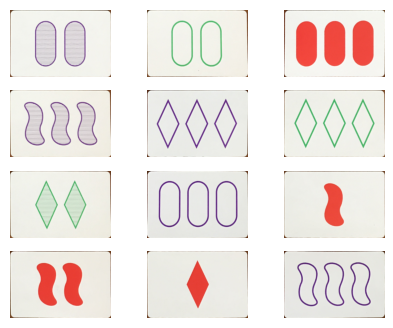

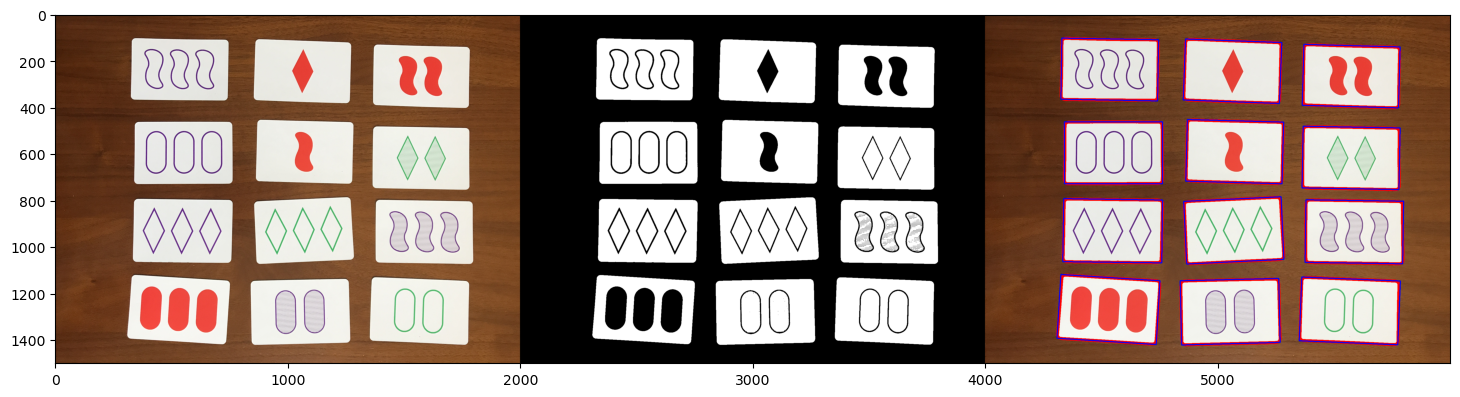

In [53]:
# process an image of all cards on the table.
# return the open image and a list of card objects
# of class SetCard, one for each of the cards in the image
set_cards, img_cards = find_card_contours(image_paths[0])

## Find contours of shapes on cards

In [54]:
def get_shapes_on_cards(card, area_thresh=4000):
    # Takes a card object of class SetCard,
    # finds all shapes on a card.
    # Modify the card object by updating the
    # shape contours and shape bounding boxes lists,
    # as well as the card label number.

    # copy the image of the card from object
    card_img = card.image.copy()
    # convert the image color to gray
    gray_img = cv.cvtColor(card_img, cv.COLOR_RGB2GRAY)
    # blur the image
    blur_img = cv.GaussianBlur(gray_img, (5, 5), cv.BORDER_DEFAULT)
    # find the optimal threshold value with Otsu's thresholding
    ret, otsu = cv.threshold(blur_img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # threshold the image using Otsu's threshold value
    ret, thresh_img = cv.threshold(blur_img, ret + 10, 255, cv.THRESH_BINARY_INV)
    # find the contours of shapes in the image (on the card)
    contours, hierarchy = cv.findContours(thresh_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # set card shapes (shape contours) and shape boxes to empty list
    card.shapes_contours = []
    card.shapes_boxes = []
    # loop through all the contours and append to list if area meets threshold
    for cnt in contours:
        # get the area of the contour
        area = cv.contourArea(cnt)
        if area > area_thresh:
            x, y, w, h = cv.boundingRect(cnt)
            card.shapes_contours.append(cnt)
            card.shapes_boxes.append((x, y, w, h))
    # set card label number to the number of shapes found - 1
    card.number = len(card.shapes_contours) - 1

    return

In [55]:
# loop through all set card objects in the list of cards
# and get the shapes on each card
for card in set_cards[:]:
    get_shapes_on_cards(card)

In [56]:
# print the updated matrix of card labels,
# labels for number of shapes on a card should be complete
[card.matrix() for card in set_cards]

[[-1, -1, -1, 1],
 [-1, -1, -1, 1],
 [-1, -1, -1, 2],
 [-1, -1, -1, 2],
 [-1, -1, -1, 2],
 [-1, -1, -1, 2],
 [-1, -1, -1, 1],
 [-1, -1, -1, 2],
 [-1, -1, -1, 0],
 [-1, -1, -1, 1],
 [-1, -1, -1, 0],
 [-1, -1, -1, 2]]

## Shape Detection
Determine the shape on a card by comparing to labeled shapes on disk.

In [57]:
# load images of shapes from disk. 
# images represent the combinations of
# shape (diamond, oval, squiggle) and shading (solid, open, stripe).

# path to the directory with images of shapes for comparing
SHAPES_DIR = "../shapes"

# list of paths to all images of shapes
shape_paths = list(paths.list_images(SHAPES_DIR))
print(f"loading {len(shape_paths)} images from shapes directory...")

loading 9 images from shapes directory...


In [58]:
shape_paths

['../shapes/squiggle_stripe.jpg',
 '../shapes/diamond_solid.jpg',
 '../shapes/diamond_open.jpg',
 '../shapes/oval_stripe.jpg',
 '../shapes/diamond_stripe.jpg',
 '../shapes/squiggle_open.jpg',
 '../shapes/squiggle_solid.jpg',
 '../shapes/oval_solid.jpg',
 '../shapes/oval_open.jpg']

In [59]:
def load_shapes_train(shapes_train):
    # function that reads the images of shapes from disk
    # and returns lists of shape labels, images of shapes,
    # and outer contours of shapes. Images loaded from disk
    # are binary and have had thresholding performed.

    labels = []  # list of labels (shape and pattern)
    shape_images = []  # list of images (shapes)
    shape_contours = []  # list of outer contours of shapes

    for path in shapes_train:
        # extract the shape and pattern label from path and filename
        shape, pattern = path.split("/")[-1].strip(".jpg").split("_")
        # save the shape and pattern labels to list of labels
        labels.append((shape, pattern))
        # read the image from disk
        img = cv.imread(path)
        # convert the color from BGR to GRAY
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # finds the outer contours in the image
        contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        # loops through the contours and saves contours with an area greater than 4000 to list of contours
        for cnt in contours:
            # get the area of the contour
            area = cv.contourArea(cnt)
            if area > 4000:
                shape_contours.append(cnt)
        # save the image to the list of images
        shape_images.append(img)

    return labels, shape_images, shape_contours

In [60]:
shapesTrainLabels, shapesTrain, contoursTrain = load_shapes_train(shape_paths)

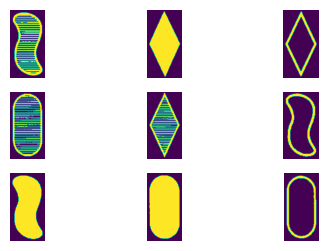

In [61]:
# show the labeled images of shapes from disk for comparison
plot_cards(shapesTrain)

In [62]:
def compare_shapes(labels, shape_images, shape_contours, cur_shape, cur_contour):
    # function uses cv.matchShapes and compares
    # the current shape contour on the card
    # to all shape contours in the training set.
    # returns the best match for shape "diamond", "oval", "squiggle"

    # number of shapes in the training set
    n = len(shape_images)
    # array to keep results of contour comparisons
    contours_results = [0] * n
    # loop through all the shapes in the training set
    # and compare them to the current shape contour
    for i in range(n):
        # select ith contour from training set
        cnt = shape_contours[i]
        # compare training contour to current contour
        contour_res = cv.matchShapes(cnt, cur_contour, 1, 0.0)
        # save result of contour comparison
        contours_results[i] = contour_res
    # choose the index with the minimum score
    contour_idx = np.argmin(contours_results)
    # choose the best contour to predict the shape label
    shape_prediction = labels[contour_idx][0]

    # visualize the results
    plt.figure(figsize=(3,2))
    plt.suptitle(f"Shape score: {np.round(contours_results[contour_idx], 4)} Result: {labels[contour_idx][0]}", fontsize=8)
    plt.subplot(1,2,1)
    plt.imshow(shapesTrain[contour_idx], cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(cur_shape, cmap="gray")
    plt.show()

    return shape_prediction

In [63]:
def get_shape_labels(card):
    # function takes a setCard object and
    # sets its shape label

    # read the image of the card
    img = card.image
    # get the bounding box for the first
    # shape on the card (x, y, w, h)
    box = card.shapes_boxes[0]
    # unpack the box tuple
    x, y, w, h = box
    # slice the image, crop to first shape on the card
    shape_img = img[y - 5:y + h + 5, x - 5:x + w + 5]
    # blur the image of the shape
    blur = cv.GaussianBlur(shape_img, (3, 3), 0)
    # convert the image color from RGB to GRAY
    gray_img = cv.cvtColor(blur, cv.COLOR_RGB2GRAY)
    # threshold the image
    ret, thresh_img = cv.threshold(gray_img, 220, 255, cv.THRESH_BINARY_INV, 0)
    # get the shape label as a string
    shape_prediction = compare_shapes(shapesTrainLabels, shapesTrain, contoursTrain, thresh_img, card.shapes_contours[0])
    # set the shape label 0:"diamond", 1:"oval", 2:"squiggle"
    card.shape = LABELS_MAP["shape"][shape_prediction]

    return

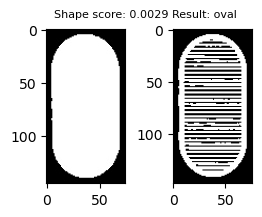

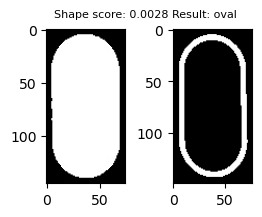

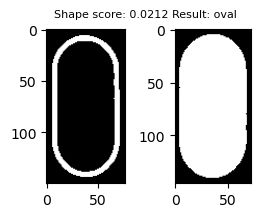

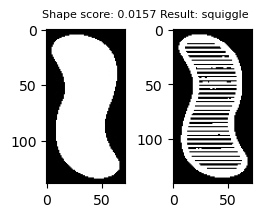

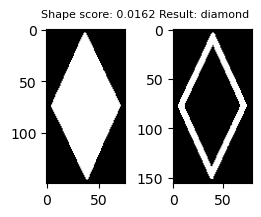

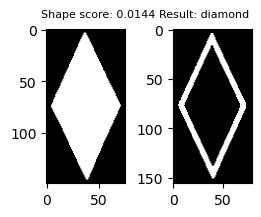

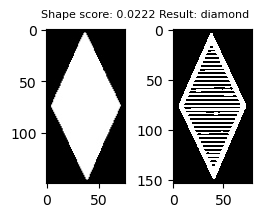

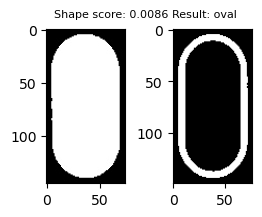

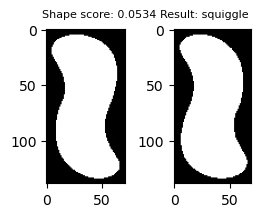

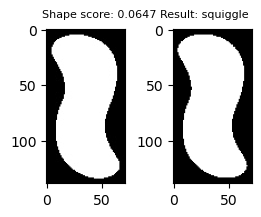

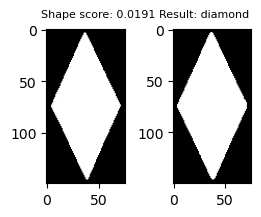

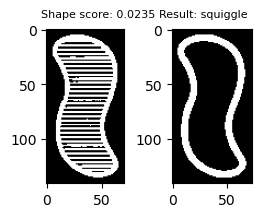

In [64]:
# loop through all set card objects in the list of cards
# and get the shape labels for each card 
for card in set_cards[:]:
    get_shape_labels(card)   

In [65]:
# print the updated matrix of card labels,
# labels for shapes on a card should now be complete
[card.matrix() for card in set_cards]

[[1, -1, -1, 1],
 [1, -1, -1, 1],
 [1, -1, -1, 2],
 [2, -1, -1, 2],
 [0, -1, -1, 2],
 [0, -1, -1, 2],
 [0, -1, -1, 1],
 [1, -1, -1, 2],
 [2, -1, -1, 0],
 [2, -1, -1, 1],
 [0, -1, -1, 0],
 [2, -1, -1, 2]]

## Shading Detection
Detect the shading of shapes on Set cards.

In [66]:
def check_shading(thresh_img):
    # takes a binary image (threshold) of a shape from a card
    # returns the shading label as a string: "solid", "open", "stripe".
    
    # find the coordinates for the middle of the image
    x, y = thresh_img.shape[1] // 2, thresh_img.shape[0] // 2
    # slice the image, get a patch from the middle of the image of size 20x20
    patch = thresh_img[y-10:y+10, x-10:x+10]
    # average value of pixels in the patch
    patch_val = int(np.mean(patch))
    # check for the shading using the average of pixel values in the patch
    # a solid shading is completely white, all pixels are 255
    if patch_val == 255:
        shading_label = "solid"
    # a open shading is completely black, all pixels are 0
    elif patch_val == 0:
        shading_label = "open"
    # a stripe shading is both white and black,
    # 0 < average pixel values in patch < 255
    else:
        shading_label = "stripe"
        
    return shading_label, patch_val

In [67]:
def get_shading_labels(card):
    # function takes a SetCard object and
    # sets its shading label

    # read the image of the card
    img = card.image
    # get the bounding box for the first
    # shape on the card (x, y, w, h)
    box = card.shapes_boxes[0]
    # unpack the box tuple
    x, y, w, h = box
    # slice the image, crop to first shape on the card
    shape_img = img[y - 5:y + h + 5, x - 5:x + w + 5]
    # blur the image of the shape
    blur = cv.GaussianBlur(shape_img, (3, 3), 0)
    # convert the image color from RGB to GRAY
    gray_img = cv.cvtColor(blur, cv.COLOR_RGB2GRAY)
    # threshold the image
    ret, thresh_img = cv.threshold(gray_img, 215, 255, cv.THRESH_BINARY_INV, 0)
    # get the shading label as a string
    shading_label, patch_val = check_shading(thresh_img)
    # set the pattern label 0:"solid", 1:"open", 2:"stripe"
    card.shading = LABELS_MAP["shading"][shading_label]

    # visualize the results
    print(patch_val, shading_label)
    plt.figure(figsize=(2,2))
    plt.imshow(thresh_img, cmap="gray")
    plt.show()

    return

132 stripe


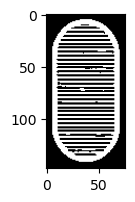

0 open


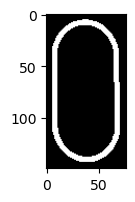

255 solid


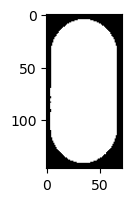

135 stripe


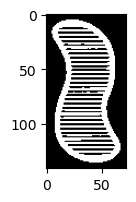

0 open


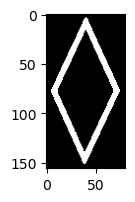

0 open


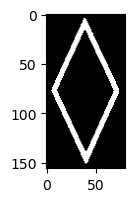

84 stripe


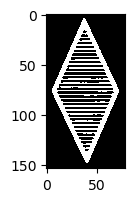

0 open


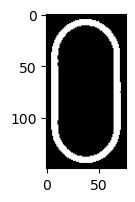

255 solid


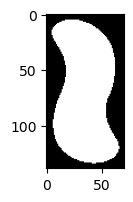

255 solid


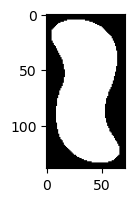

255 solid


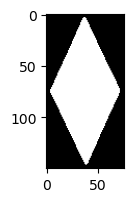

0 open


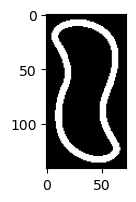

In [68]:
for card in set_cards:
    get_shading_labels(card)

In [69]:
# print the updated matrix of card labels,
# labels for shading on a card should now be complete
[card.matrix() for card in set_cards]

[[1, -1, 2, 1],
 [1, -1, 1, 1],
 [1, -1, 0, 2],
 [2, -1, 2, 2],
 [0, -1, 1, 2],
 [0, -1, 1, 2],
 [0, -1, 2, 1],
 [1, -1, 1, 2],
 [2, -1, 0, 0],
 [2, -1, 0, 1],
 [0, -1, 0, 0],
 [2, -1, 1, 2]]

## Color Detection
Detect the color of shapes on SET cards.

In [70]:
def mask_score(mask, color):
    # Function calculates the proportion of
    # pixels in the mask representing a color
    # and returns the float value used for scoring

    # count the number of pixels with value 255
    count = 0
    # number of rows
    n = len(mask)
    # number of columns
    m = len(mask[0])
    # loop through all pixels in the mask
    for i in range(n):
        for j in range(m):
            # check if pixel value equals 255
            if mask[i][j] == 255:
                count += 1
    # total number of pixels in mask
    pixels = n * m
    # calculate the score by dividing the count of pixels
    # equal to 255 by the total number of pixels in the maks
    score = count / pixels
    # visualize the results
    print(f"found {count} {color} pixels out of {pixels} total pixels")
    print(f"{np.round(score * 100, 4)}% of pixels are {color}")
    
    return score

In [71]:
def check_colors(hsv):
    # function takes an image of a shape in hsv color,
    # detects the color of the shape using cv.inRange
    # for three colors: red, green, and purple.
    # returns the integer label 0: "red", 1: "green", 2: "purple"

    # ordered list of colors to detect
    colors = ["red", "green", "purple"]
    # list of inRange color masks
    masks = []
    # list of color scores
    scores = [0.0] * 3
    # boundaries of red, green, and purple is hsv color
    color_boundaries = [([0, 50, 64], [30, 255, 255]),
                        ([50, 10, 64], [80, 255, 255]),
                        ([130, 10, 64], [160, 255, 255])]
    # loop over the boundaries
    for i, boundary in enumerate(color_boundaries):
        # create NumPy arrays from the boundaries
        lower = np.array(boundary[0], dtype="uint8")
        upper = np.array(boundary[1], dtype="uint8")
        # find the colors within the specified boundaries and apply the mask
        mask = cv.inRange(hsv, lower, upper)
        # append the resulting mask to the list of masks
        masks.append(mask)
        # calculate the score of the mask
        scores[i] = mask_score(mask, colors[i])
    # result is the index of the maximum score
    res = np.argmax(scores)

    return masks[res], colors[res], res

In [72]:
def get_color_labels(card):
    # function takes a SetCard object and
    # sets its color label

    # read the image of the card
    img = card.image
    # get the bounding box for the first
    # shape on the card (x, y, w, h)
    box = card.shapes_boxes[0]
    # unpack the box tuple
    x, y, w, h = box
    # slice the image, crop to first shape on the card
    shape_img = img[y - 5:y + h + 5, x - 5:x + w + 5]
    # blur the image of the shape
    blur = cv.GaussianBlur(shape_img, (3, 3), 0)
    # convert the image color from RGB to HSV
    hsv = cv.cvtColor(blur, cv.COLOR_RGB2HSV)
    # detect the color of the shape from HSV image and
    # set the color label 0: "red", 1: "green", 2: "purple"
    mask, color, res = check_colors(hsv)
    card.color = res
    # visualize the results
    output = cv.bitwise_and(shape_img, shape_img, mask=mask)

    plt.figure(figsize=(3,2))
    plt.imshow(np.hstack([shape_img, blur, output]))
    plt.title(color.title(), fontsize=8)
    plt.axis('off')
    plt.show()

    return

found 0 red pixels out of 11248 total pixels
0.0% of pixels are red
found 0 green pixels out of 11248 total pixels
0.0% of pixels are green
found 1947 purple pixels out of 11248 total pixels
17.3097% of pixels are purple


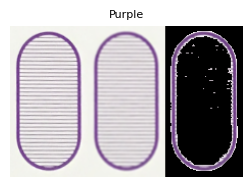

found 0 red pixels out of 11473 total pixels
0.0% of pixels are red
found 2193 green pixels out of 11473 total pixels
19.1144% of pixels are green
found 0 purple pixels out of 11473 total pixels
0.0% of pixels are purple


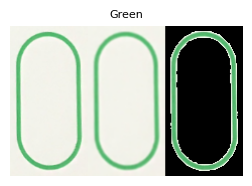

found 7622 red pixels out of 10512 total pixels
72.5076% of pixels are red
found 0 green pixels out of 10512 total pixels
0.0% of pixels are green
found 0 purple pixels out of 10512 total pixels
0.0% of pixels are purple


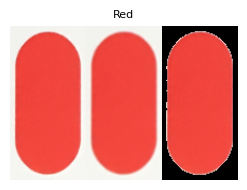

found 0 red pixels out of 10293 total pixels
0.0% of pixels are red
found 0 green pixels out of 10293 total pixels
0.0% of pixels are green
found 1856 purple pixels out of 10293 total pixels
18.0317% of pixels are purple


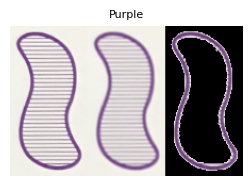

found 0 red pixels out of 12480 total pixels
0.0% of pixels are red
found 0 green pixels out of 12480 total pixels
0.0% of pixels are green
found 1895 purple pixels out of 12480 total pixels
15.1843% of pixels are purple


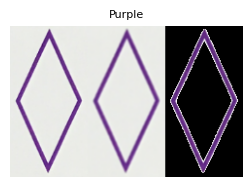

found 0 red pixels out of 12480 total pixels
0.0% of pixels are red
found 2126 green pixels out of 12480 total pixels
17.0353% of pixels are green
found 0 purple pixels out of 12480 total pixels
0.0% of pixels are purple


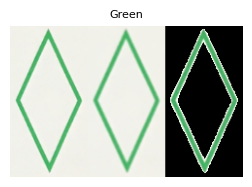

found 0 red pixels out of 12166 total pixels
0.0% of pixels are red
found 5292 green pixels out of 12166 total pixels
43.4983% of pixels are green
found 0 purple pixels out of 12166 total pixels
0.0% of pixels are purple


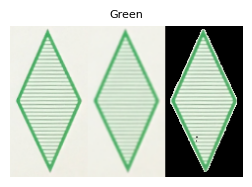

found 0 red pixels out of 11473 total pixels
0.0% of pixels are red
found 0 green pixels out of 11473 total pixels
0.0% of pixels are green
found 2174 purple pixels out of 11473 total pixels
18.9488% of pixels are purple


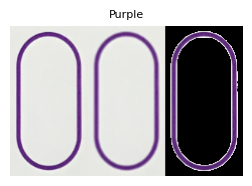

found 5828 red pixels out of 9730 total pixels
59.8972% of pixels are red
found 0 green pixels out of 9730 total pixels
0.0% of pixels are green
found 0 purple pixels out of 9730 total pixels
0.0% of pixels are purple


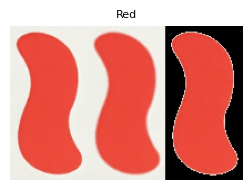

found 5831 red pixels out of 9869 total pixels
59.084% of pixels are red
found 0 green pixels out of 9869 total pixels
0.0% of pixels are green
found 0 purple pixels out of 9869 total pixels
0.0% of pixels are purple


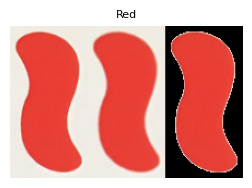

found 4983 red pixels out of 11400 total pixels
43.7105% of pixels are red
found 0 green pixels out of 11400 total pixels
0.0% of pixels are green
found 0 purple pixels out of 11400 total pixels
0.0% of pixels are purple


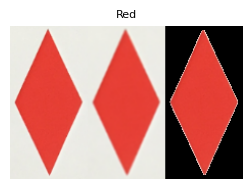

found 0 red pixels out of 10293 total pixels
0.0% of pixels are red
found 0 green pixels out of 10293 total pixels
0.0% of pixels are green
found 1974 purple pixels out of 10293 total pixels
19.1781% of pixels are purple


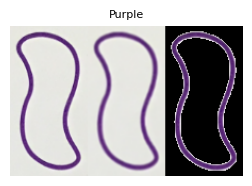

In [73]:
for card in set_cards[:]:
    get_color_labels(card)

In [74]:
# print the complete matrix of card labels
[card.matrix() for card in set_cards]

[[1, 2, 2, 1],
 [1, 1, 1, 1],
 [1, 0, 0, 2],
 [2, 2, 2, 2],
 [0, 2, 1, 2],
 [0, 1, 1, 2],
 [0, 1, 2, 1],
 [1, 2, 1, 2],
 [2, 0, 0, 0],
 [2, 0, 0, 1],
 [0, 0, 0, 0],
 [2, 2, 1, 2]]

## Visualize the results
Plot a grid of labeled SET playing cards

In [75]:
def plotCardsWithLabels(cards):
    n = len(cards)
    cols = 3
    rows = int(np.ceil(n / 3))
    plt.figure(figsize=(9, rows * 3))
    for i in range(n):
        card = cards[i]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(card.image)
        plt.title(f"Shape: {SET_MAP['shape'][card.shape]}\nColor: {SET_MAP['color'][card.color]}\nShading: {SET_MAP['shading'][card.shading]}\nNumber: {SET_MAP['number'][card.number]}", fontsize=8)
        plt.axis("off")
    plt.show()
    return

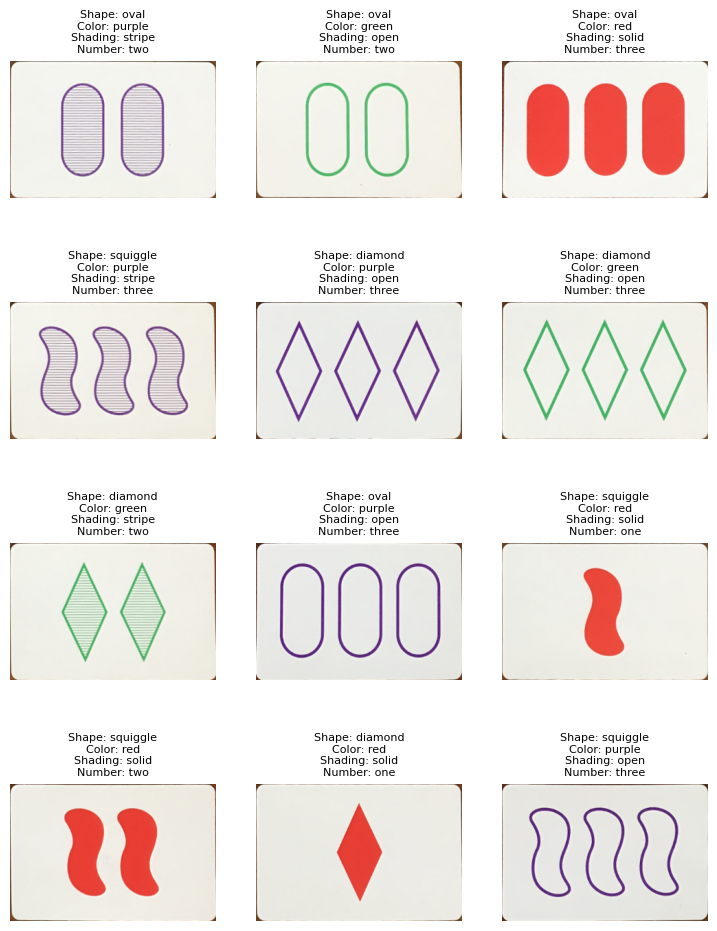

In [76]:
plotCardsWithLabels(set_cards)

## Annotate the original image
Draw bounding rectangles around cards and put text with card labels on the original image of SET playing cards.

In [77]:
def annotate_cards_image(set_cards, annotate_img):
    # convert the color of the image from RGB to BGR
    # annotate_img = cv.cvtColor(annotate_img, cv.COLOR_RGB2BGR)
    # loop through all card objects in list
    for card in set_cards:
        # draw boxes around cards
        cv.drawContours(annotate_img, [card.box], -1, (0, 255, 0), 5)
        # build the string for putting text on the image
        text = ""
        for i, key in enumerate(SET_MAP.keys()):
            text += SET_MAP[key][card.matrix()[i]].title()
            if i < len(SET_MAP.keys()) - 1:
                text += " "
        # get x, y coordinates for text
        x, y, w, h = card.bbox[0]
        # get text size
        text_size = cv.getTextSize(text, cv.FONT_HERSHEY_PLAIN, 1.3, 2)
        dim = text_size[0]
        baseline = text_size[1]
        # Use text size to create a black rectangle
        cv.rectangle(annotate_img, (x, y - dim[1] - baseline), (x + dim[0], y + baseline), (0, 0, 0), cv.FILLED)
        # put text labels on the image
        cv.putText(annotate_img, text, (x, y), cv.FONT_HERSHEY_PLAIN, 1.3, (0, 255, 255), 2)

    return annotate_img

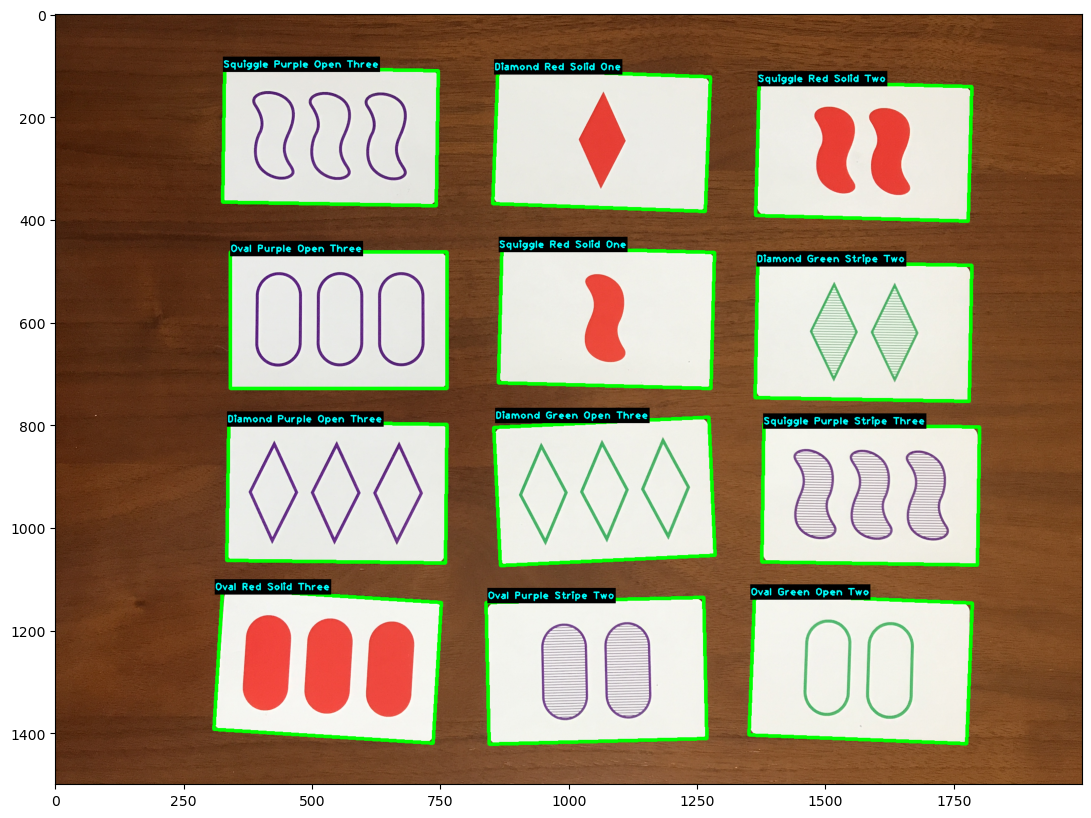

In [78]:
# show the annotated image
plt.figure(figsize=(15,10))
plt.imshow(annotate_cards_image(set_cards, img_cards))
plt.show()